<h1>Machine Learning approach to achieve efficient DMFT solution<h1>

<p>We use DMFT with exact diagonalization (ED) as impurity solver<p> 
<p>ED solver require intinsic parameter called bath orbital obtain using optization fit to bath funtion<p>

$$\mathcal{G}^0(i\omega_n) = -i\omega_n+T +\sum_i\frac{V_i}{i\omega_n+\epsilon_i}$$ 
    
    
    
<p>where 'i' is the number of bath orbital<p>

In [1]:
#----Initialization----------------------
import numpy as np
import pandas as pd
import tensorflow
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.special import softmax
from scipy import sparse
import math
pi=math.pi
exp=math.exp

<p> Idea is to get the green's funtion for low number of orbital and train a model with an output with 8 obital<p>
 <p> $$i\omega_n=256$$, $$U=3-5 (100)$$ and $$N_b=2,3,6$$<p>

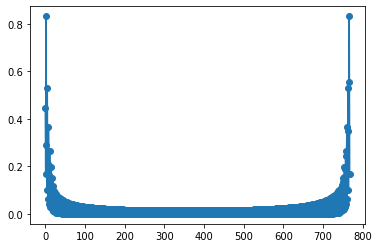

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.4446,0.1684,0.8306,0.2895,0.0990,0.5297,0.2095,0.0625,0.3654,0.1653,...,0.0421,0.2440,0.3652,0.0630,0.3474,0.5300,0.0998,0.5554,0.8316,0.1694
1,0.5150,0.5262,0.7156,0.3621,0.3758,0.5161,0.2744,0.2892,0.3957,0.2205,...,0.0927,0.2666,0.2596,0.1281,0.3468,0.3388,0.1853,0.4850,0.4738,0.2844
2,0.5179,0.5283,0.2507,0.3570,0.3711,0.1592,0.2676,0.2834,0.1077,0.2139,...,0.3090,0.2587,0.2541,0.3945,0.3393,0.3332,0.5263,0.4821,0.4717,0.7493
3,0.4749,0.1845,0.7883,0.3190,0.1105,0.5226,0.2371,0.0709,0.3757,0.1903,...,0.0593,0.2481,0.3748,0.0848,0.3426,0.5324,0.1288,0.5251,0.8155,0.2117
4,0.7243,0.5274,0.7363,0.5161,0.3728,0.5226,0.3931,0.2855,0.3953,0.3135,...,0.0826,0.1221,0.2563,0.1154,0.1776,0.3354,0.1692,0.2757,0.4726,0.2637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.5205,0.5188,0.2264,0.3527,0.3577,0.1410,0.2616,0.2702,0.0937,0.2082,...,0.3000,0.2517,0.2577,0.3901,0.3326,0.3377,0.5308,0.4795,0.4812,0.7736
96,0.4691,0.5262,0.7135,0.3313,0.3759,0.5151,0.2511,0.2893,0.3953,0.2013,...,0.0938,0.2828,0.2597,0.1293,0.3727,0.3389,0.1869,0.5309,0.4738,0.2865
97,0.2255,0.2151,0.2171,0.1398,0.1327,0.1341,0.0929,0.0874,0.0885,0.0649,...,0.2958,0.3882,0.3876,0.3876,0.5286,0.5327,0.5319,0.7745,0.7849,0.7829
98,0.4848,0.5263,0.2821,0.3464,0.3755,0.1835,0.2661,0.2888,0.1267,0.2162,...,0.3161,0.2740,0.2593,0.3958,0.3618,0.3385,0.5170,0.5152,0.4737,0.7179


In [9]:
inp_up=np.loadtxt('Gnfnup.dat') # input with 2,4,6 orbital 100 random U
inp_dw=np.loadtxt('Gnfndw.dat')
out_up=np.loadtxt('Gfup.dat') # output with 8 orbital 100
out_dw=np.loadtxt('Gfdw.dat')
#------------------To cross check we reshape-------------
Ginp_up=np.reshape(inp_up, (100,256*3), order='C')
Ginp_dw=np.reshape(inp_dw, (100,256*3),order='C')
Gout_up=np.reshape(out_up, (100,256),order='C')
Gout_dw=np.reshape(out_dw, (100,256),order='C')
plt.plot(Ginp_up[0,:],'o-')
plt.show()
tmp=np.reshape(inp_up, (100,256,3), order='C')
tmpdw=np.reshape(inp_dw, (100,256,3), order='C')
Ginp_uporb=pd.DataFrame(Ginp_up)   
display(Ginp_uporb)

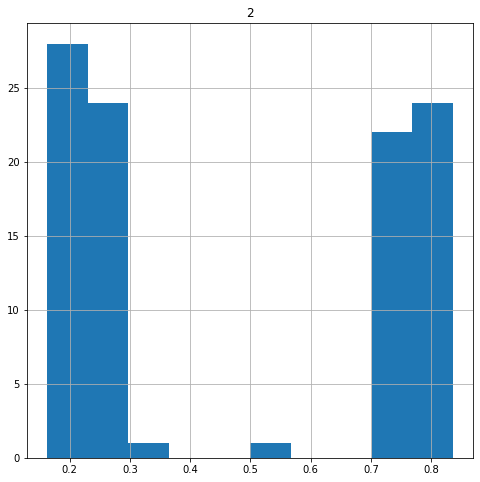

In [12]:

Ginp_uporb.hist(column=2, sharey=True, figsize=(8,8))
plt.show()

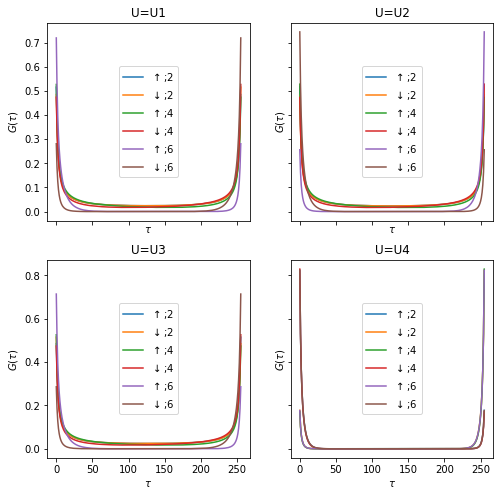

In [10]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(8, 8))
ax[0,0].plot(tmp[5,:,0],'-',label=r'$\uparrow$;2')
ax[0,0].plot(tmpdw[5,:,0],'-',label=r'$\downarrow$;2')
ax[0,0].plot(tmp[5,:,1],'-',label=r'$\uparrow$;4')
ax[0,0].plot(tmpdw[5,:,1],'-',label=r'$\downarrow$;4')
ax[0,0].plot(tmp[5,:,2],'-',label=r'$\uparrow$;6')
ax[0,0].plot(tmpdw[5,:,2],'-',label=r'$\downarrow$;6')
ax[0,0].set(xlabel=r'$\tau$')
ax[0,0].legend(loc='center')
ax[0,0].set(ylabel=r'$G(\tau)$')
ax[0, 0].set_title("U=U1")

ax[0,1].plot(tmp[20,:,0],'-',label=r'$\uparrow$;2')
ax[0,1].plot(tmpdw[20,:,0],'-',label=r'$\downarrow$;2')
ax[0,1].plot(tmp[20,:,1],'-',label=r'$\uparrow$;4')
ax[0,1].plot(tmpdw[20,:,1],'-',label=r'$\downarrow$;4')
ax[0,1].plot(tmp[20,:,2],'-',label=r'$\uparrow$;6')
ax[0,1].plot(tmpdw[20,:,2],'-',label=r'$\downarrow$;6')
ax[0,1].set(xlabel=r'$\tau$')
ax[0,1].legend(loc='center')
ax[0,1].set(ylabel=r'$G(\tau)$')
ax[0,1].set_title("U=U2")
ax[1,0].plot(tmp[60,:,0],'-',label=r'$\uparrow$;2')
ax[1,0].plot(tmpdw[60,:,0],'-',label=r'$\downarrow$;2')
ax[1,0].plot(tmp[60,:,1],'-',label=r'$\uparrow$;4')
ax[1,0].plot(tmpdw[60,:,1],'-',label=r'$\downarrow$;4')
ax[1,0].plot(tmp[60,:,2],'-',label=r'$\uparrow$;6')
ax[1,0].plot(tmpdw[60,:,2],'-',label=r'$\downarrow$;6')
ax[1,0].set(xlabel=r'$\tau$')
ax[1,0].legend(loc='center')
ax[1,0].set(ylabel=r'$G(\tau)$')
ax[1,0].set_title("U=U3")
ax[1,1].plot(tmp[80,:,0],'-',label=r'$\uparrow$;2')
ax[1,1].plot(tmpdw[80,:,0],'-',label=r'$\downarrow$;2')
ax[1,1].plot(tmp[80,:,1],'-',label=r'$\uparrow$;4')
ax[1,1].plot(tmpdw[80,:,1],'-',label=r'$\downarrow$;4')
ax[1,1].plot(tmp[80,:,2],'-',label=r'$\uparrow$;6')
ax[1,1].plot(tmpdw[80,:,2],'-',label=r'$\downarrow$;6')
ax[1,1].set(xlabel=r'$\tau$')
ax[1,1].legend(loc='center')
ax[1,1].set(ylabel=r'$G(\tau)$')
ax[1,1].set_title("U=U4")
plt.show()

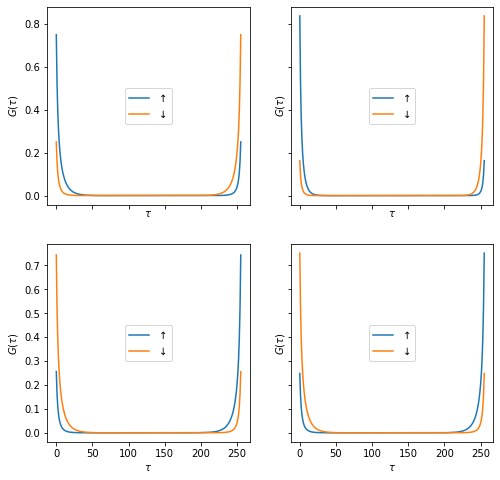

In [11]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(8, 8))
ax[0,0].plot(Gout_up[2,:],'-',label=r'$\uparrow$')
ax[0,0].plot(Gout_dw[2,:],'-',label=r'$\downarrow$')
ax[0,0].set(xlabel=r'$\tau$')
ax[0,0].legend(loc='center')
ax[0,0].set(ylabel=r'$G(\tau)$')
ax[0,1].plot(Gout_up[10,:],'-',label=r'$\uparrow$')
ax[0,1].plot(Gout_dw[10,:],'-',label=r'$\downarrow$')
ax[0,1].set(xlabel=r'$\tau$')
ax[0,1].legend(loc='center')
ax[0,1].set(ylabel=r'$G(\tau)$')
ax[1,0].plot(Gout_up[20,:],'-',label=r'$\uparrow$')
ax[1,0].plot(Gout_dw[20,:],'-',label=r'$\downarrow$')
ax[1,0].set(xlabel=r'$\tau$')
ax[1,0].legend(loc='center')
ax[1,0].set(ylabel=r'$G(\tau)$')

ax[1,1].plot(Gout_up[40,:],'-',label=r'$\uparrow$')
ax[1,1].plot(Gout_dw[40,:],'-',label=r'$\downarrow$')
ax[1,1].set(xlabel=r'$\tau$')
ax[1,1].legend(loc='center')
ax[1,1].set(ylabel=r'$G(\tau)$')
plt.show()

In [12]:
def randomgrin(n):
    import random
    sin=np.zeros((100,256*3))
    np.random.seed(n)
    for i in range (100):
        sin[i,:]=np.random.normal(0.5,0.1)
    sin=sin/(np.amax(sin)*100)
    return sin

In [13]:
Ginp_up_s1=Ginp_up+randomgrin(1)
Ginp_up_s2=Ginp_up+randomgrin(2)
Ginp_up_s3=Ginp_up+randomgrin(3)
Ginp_up_s4=Ginp_up+randomgrin(4)
Ginp_up_s5=Ginp_up+randomgrin(5)

In [14]:
def randomgrout(n):
    import random
    sout=np.zeros((100,256))
    np.random.seed(n)
    for i in range (100):
        sout[i,:]=np.random.normal(0.5,0.1)
    sout=sout/(np.amax(sout)*100)
    return sout

In [15]:
Gout_up_s1=Gout_up+randomgrout(1)
Gout_up_s2=Gout_up+randomgrout(2)
Gout_up_s3=Gout_up+randomgrout(3)
Gout_up_s4=Gout_up+randomgrout(4)
Gout_up_s5=Gout_up+randomgrout(5)

In [16]:
X=np.vstack((Ginp_up,Ginp_up_s1,Ginp_up_s2,Ginp_up_s3,Ginp_up_s4,Ginp_up_s5))
y=np.vstack((Gout_up,Gout_up_s1,Gout_up_s2,Gout_up_s3,Gout_up_s4,Gout_up_s5))

In [17]:
df = pd.DataFrame(data=X)

In [18]:
df2=df.round(2)
X=df2.to_numpy()

In [19]:
#-------------------------

#print (X)
print(X.shape, y.shape)
X_train=X[0:500,:]
X_test=X[500:600,:]
y_train=y[0:500,:]
y_test=y[500:600,:]
print(y_train.shape)


(600, 768) (600, 256)
(500, 256)


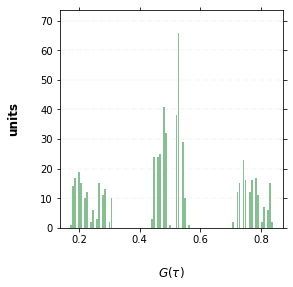

In [20]:
import pandas as pd
df=pd.DataFrame(X)
#display(df)
#df.hist(column=0,bins=50, grid=False, figsize=(10,6), color='#86bf91', zorder=2, rwidth=0.9)
ax = df.hist(column=0, bins=100, grid=False, figsize=(4,4), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="on", top="on", labelbottom="on", left="on", right="on", labelleft="on")
    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel(r"$G(\tau)$", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("units", labelpad=20, weight='bold', size=12)

    

In [65]:
columns=[]
for i in range(768):
    x="col"+"_"+str(i)
    columns.append(x)
columns

['col_0',
 'col_1',
 'col_2',
 'col_3',
 'col_4',
 'col_5',
 'col_6',
 'col_7',
 'col_8',
 'col_9',
 'col_10',
 'col_11',
 'col_12',
 'col_13',
 'col_14',
 'col_15',
 'col_16',
 'col_17',
 'col_18',
 'col_19',
 'col_20',
 'col_21',
 'col_22',
 'col_23',
 'col_24',
 'col_25',
 'col_26',
 'col_27',
 'col_28',
 'col_29',
 'col_30',
 'col_31',
 'col_32',
 'col_33',
 'col_34',
 'col_35',
 'col_36',
 'col_37',
 'col_38',
 'col_39',
 'col_40',
 'col_41',
 'col_42',
 'col_43',
 'col_44',
 'col_45',
 'col_46',
 'col_47',
 'col_48',
 'col_49',
 'col_50',
 'col_51',
 'col_52',
 'col_53',
 'col_54',
 'col_55',
 'col_56',
 'col_57',
 'col_58',
 'col_59',
 'col_60',
 'col_61',
 'col_62',
 'col_63',
 'col_64',
 'col_65',
 'col_66',
 'col_67',
 'col_68',
 'col_69',
 'col_70',
 'col_71',
 'col_72',
 'col_73',
 'col_74',
 'col_75',
 'col_76',
 'col_77',
 'col_78',
 'col_79',
 'col_80',
 'col_81',
 'col_82',
 'col_83',
 'col_84',
 'col_85',
 'col_86',
 'col_87',
 'col_88',
 'col_89',
 'col_90',
 'col_91'

<AxesSubplot:xlabel='index'>

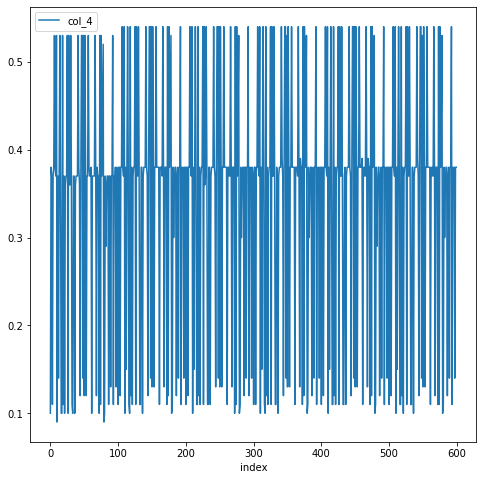

In [80]:
df.columns=columns
df.index
#display(df)
#df.reset_index().plot(x='index', y='col_4',figsize=(8,8))
#plt.show()



<h2>For now, we do not use PCA<h2> 

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
scikit_pca = PCA(n_components=3)
scikit_pca.fit(X_train)
X_pca_train=scikit_pca.transform(X_train)
print(X_pca_train.shape)
X_train_w=scikit_pca.components_
print(scikit_pca.components_)

scikit_pca.fit(X_test)
X_pca_test=scikit_pca.transform(X_test)
print(X_pca_test.shape)
print(scikit_pca.components_)
print(scikit_pca.components_.shape)
X_test_w=scikit_pca.components_
plt.plot(X_pca_test)

<p> Tensor network Keras to define the netwoork <p> 

In [21]:
from keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2
# define the Neural Network
model = Sequential()
model.add(Dense(32, activation = 'relu',input_shape=(256*3,))) 
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256))

In [22]:
tensorflow.keras.utils.plot_model(model)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                24608     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4

In [24]:
# Lets look at the model's prediction before training it
pred = model(X_train)
print(pred.shape)
#plt.plot(pred)

(500, 256)


In [25]:
# here you compile the model and choose the optimizer and loss for the training
#opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(
   loss = 'mse', 
   optimizer = RMSprop(), 
   metrics = ['accuracy']
)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
   X_train, y_train,    
   batch_size=10, 
   epochs = 1000, 
   verbose = 1, 
   validation_data=(X_test,y_test), 
   #callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)]
)

Epoch 1/1000
50/50 [==============================] - 2s 8ms/step - loss: 0.0039 - accuracy: 0.5140 - val_loss: 0.0023 - val_accuracy: 0.5900
Epoch 2/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.5680 - val_loss: 0.0017 - val_accuracy: 0.5900
Epoch 3/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.6020 - val_loss: 0.0015 - val_accuracy: 0.5900
Epoch 4/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.5840 - val_loss: 0.0014 - val_accuracy: 0.5900
Epoch 5/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.5860 - val_loss: 0.0014 - val_accuracy: 0.5900
Epoch 6/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.5960 - val_loss: 0.0014 - val_accuracy: 0.5900
Epoch 7/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.5840 - val_loss: 0.0014 - val_accuracy: 0.5900
Epoch 

50/50 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.6860 - val_loss: 0.0010 - val_accuracy: 0.7400
Epoch 59/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7060 - val_loss: 9.9802e-04 - val_accuracy: 0.7300
Epoch 60/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7060 - val_loss: 0.0012 - val_accuracy: 0.7000
Epoch 61/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.6800 - val_loss: 0.0011 - val_accuracy: 0.7100
Epoch 62/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7220 - val_loss: 0.0010 - val_accuracy: 0.6900
Epoch 63/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.6960 - val_loss: 0.0010 - val_accuracy: 0.7300
Epoch 64/1000
50/50 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.7160 - val_loss: 9.8848e-04 - val_accuracy: 0.7600
Epoch

Epoch 114/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7420 - val_loss: 8.9695e-04 - val_accuracy: 0.7700
Epoch 115/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7340 - val_loss: 0.0011 - val_accuracy: 0.7000
Epoch 116/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7180 - val_loss: 9.4891e-04 - val_accuracy: 0.7300
Epoch 117/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7420 - val_loss: 8.7889e-04 - val_accuracy: 0.7700
Epoch 118/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7280 - val_loss: 9.1361e-04 - val_accuracy: 0.7700
Epoch 119/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7360 - val_loss: 8.8323e-04 - val_accuracy: 0.7600
Epoch 120/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7220 - val_loss: 9.

50/50 [==============================] - 0s 2ms/step - loss: 9.8570e-04 - accuracy: 0.7600 - val_loss: 8.9512e-04 - val_accuracy: 0.7700
Epoch 170/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.7191e-04 - accuracy: 0.7540 - val_loss: 8.6345e-04 - val_accuracy: 0.7900
Epoch 171/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6375e-04 - accuracy: 0.7540 - val_loss: 8.6141e-04 - val_accuracy: 0.8000
Epoch 172/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.9453e-04 - accuracy: 0.7620 - val_loss: 8.6933e-04 - val_accuracy: 0.8000
Epoch 173/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.7280 - val_loss: 9.1254e-04 - val_accuracy: 0.7600
Epoch 174/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7300 - val_loss: 9.1140e-04 - val_accuracy: 0.7500
Epoch 175/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7240 - val_los

50/50 [==============================] - 0s 2ms/step - loss: 9.9641e-04 - accuracy: 0.7600 - val_loss: 8.8189e-04 - val_accuracy: 0.7500
Epoch 224/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7400 - val_loss: 8.4124e-04 - val_accuracy: 0.7700
Epoch 225/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7400 - val_loss: 8.6502e-04 - val_accuracy: 0.7800
Epoch 226/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6717e-04 - accuracy: 0.7600 - val_loss: 8.3027e-04 - val_accuracy: 0.8100
Epoch 227/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1880e-04 - accuracy: 0.7780 - val_loss: 9.2328e-04 - val_accuracy: 0.7600
Epoch 228/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6831e-04 - accuracy: 0.7360 - val_loss: 8.2988e-04 - val_accuracy: 0.8000
Epoch 229/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.8564e-04 - accuracy: 0.7340 - val

50/50 [==============================] - 0s 2ms/step - loss: 9.4921e-04 - accuracy: 0.7520 - val_loss: 8.5572e-04 - val_accuracy: 0.8000
Epoch 278/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2719e-04 - accuracy: 0.7820 - val_loss: 8.3520e-04 - val_accuracy: 0.7900
Epoch 279/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.9214e-04 - accuracy: 0.7580 - val_loss: 8.6109e-04 - val_accuracy: 0.7800
Epoch 280/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.3018e-04 - accuracy: 0.7860 - val_loss: 8.8041e-04 - val_accuracy: 0.7700
Epoch 281/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6350e-04 - accuracy: 0.7640 - val_loss: 8.2036e-04 - val_accuracy: 0.8000
Epoch 282/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6138e-04 - accuracy: 0.7760 - val_loss: 8.4374e-04 - val_accuracy: 0.7900
Epoch 283/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.7709e-04 - accuracy: 0.75

50/50 [==============================] - 0s 2ms/step - loss: 9.9435e-04 - accuracy: 0.7520 - val_loss: 8.4537e-04 - val_accuracy: 0.8000
Epoch 332/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.8599e-04 - accuracy: 0.7560 - val_loss: 8.2971e-04 - val_accuracy: 0.8000
Epoch 333/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.9216e-04 - accuracy: 0.7420 - val_loss: 8.3404e-04 - val_accuracy: 0.8000
Epoch 334/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6427e-04 - accuracy: 0.7580 - val_loss: 8.1269e-04 - val_accuracy: 0.8100
Epoch 335/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.0153e-04 - accuracy: 0.7820 - val_loss: 8.5424e-04 - val_accuracy: 0.7900
Epoch 336/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6087e-04 - accuracy: 0.7640 - val_loss: 8.4900e-04 - val_accuracy: 0.7700
Epoch 337/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2047e-04 - accuracy: 0.77

50/50 [==============================] - 0s 2ms/step - loss: 9.4643e-04 - accuracy: 0.7700 - val_loss: 8.3439e-04 - val_accuracy: 0.7900
Epoch 386/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.7081e-04 - accuracy: 0.7500 - val_loss: 8.2331e-04 - val_accuracy: 0.7800
Epoch 387/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2680e-04 - accuracy: 0.7780 - val_loss: 9.0922e-04 - val_accuracy: 0.7700
Epoch 388/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.0692e-04 - accuracy: 0.7640 - val_loss: 7.9657e-04 - val_accuracy: 0.7800
Epoch 389/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1275e-04 - accuracy: 0.7640 - val_loss: 8.0380e-04 - val_accuracy: 0.8000
Epoch 390/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6284e-04 - accuracy: 0.7620 - val_loss: 8.5902e-04 - val_accuracy: 0.7700
Epoch 391/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.5179e-04 - accuracy: 0.77

50/50 [==============================] - 0s 2ms/step - loss: 9.1057e-04 - accuracy: 0.7860 - val_loss: 8.9027e-04 - val_accuracy: 0.7900
Epoch 440/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.3672e-04 - accuracy: 0.7680 - val_loss: 8.2803e-04 - val_accuracy: 0.7800
Epoch 441/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.3219e-04 - accuracy: 0.7620 - val_loss: 8.3168e-04 - val_accuracy: 0.8000
Epoch 442/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1863e-04 - accuracy: 0.7780 - val_loss: 8.2073e-04 - val_accuracy: 0.8000
Epoch 443/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7813e-04 - accuracy: 0.7960 - val_loss: 8.3328e-04 - val_accuracy: 0.8100
Epoch 444/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7220e-04 - accuracy: 0.7980 - val_loss: 8.1997e-04 - val_accuracy: 0.8100
Epoch 445/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.4098e-04 - accuracy: 0.76

50/50 [==============================] - 0s 3ms/step - loss: 9.5997e-04 - accuracy: 0.7480 - val_loss: 8.4735e-04 - val_accuracy: 0.7900
Epoch 494/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.4162e-04 - accuracy: 0.7580 - val_loss: 8.6671e-04 - val_accuracy: 0.8100
Epoch 495/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.8032e-04 - accuracy: 0.7340 - val_loss: 8.1589e-04 - val_accuracy: 0.8100
Epoch 496/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.7660 - val_loss: 8.3344e-04 - val_accuracy: 0.7900
Epoch 497/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9666e-04 - accuracy: 0.7680 - val_loss: 7.8940e-04 - val_accuracy: 0.8100
Epoch 498/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.5710e-04 - accuracy: 0.7640 - val_loss: 7.8446e-04 - val_accuracy: 0.8200
Epoch 499/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2627e-04 - accuracy: 0.7540 -

50/50 [==============================] - 0s 2ms/step - loss: 9.2939e-04 - accuracy: 0.7680 - val_loss: 8.4412e-04 - val_accuracy: 0.7800
Epoch 548/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2971e-04 - accuracy: 0.7780 - val_loss: 8.0204e-04 - val_accuracy: 0.8100
Epoch 549/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.5140e-04 - accuracy: 0.7620 - val_loss: 7.7464e-04 - val_accuracy: 0.8100
Epoch 550/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.4972e-04 - accuracy: 0.7540 - val_loss: 8.0680e-04 - val_accuracy: 0.8000
Epoch 551/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.0380e-04 - accuracy: 0.7600 - val_loss: 8.9698e-04 - val_accuracy: 0.7600
Epoch 552/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.7787e-04 - accuracy: 0.7600 - val_loss: 7.6966e-04 - val_accuracy: 0.8100
Epoch 553/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7239e-04 - accuracy: 0.78

Epoch 601/1000
50/50 [==============================] - 0s 3ms/step - loss: 8.8041e-04 - accuracy: 0.7780 - val_loss: 7.8492e-04 - val_accuracy: 0.8200
Epoch 602/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9249e-04 - accuracy: 0.7780 - val_loss: 8.7533e-04 - val_accuracy: 0.7800
Epoch 603/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.8054e-04 - accuracy: 0.7520 - val_loss: 8.2780e-04 - val_accuracy: 0.8100
Epoch 604/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1273e-04 - accuracy: 0.7600 - val_loss: 8.1006e-04 - val_accuracy: 0.7900
Epoch 605/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.4229e-04 - accuracy: 0.7400 - val_loss: 8.3394e-04 - val_accuracy: 0.8000
Epoch 606/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7825e-04 - accuracy: 0.7820 - val_loss: 9.7735e-04 - val_accuracy: 0.7100
Epoch 607/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.6817e-04 -

Epoch 655/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.3927e-04 - accuracy: 0.7580 - val_loss: 7.4240e-04 - val_accuracy: 0.8200
Epoch 656/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.4726e-04 - accuracy: 0.7720 - val_loss: 7.6079e-04 - val_accuracy: 0.8300
Epoch 657/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.2810e-04 - accuracy: 0.7860 - val_loss: 9.2135e-04 - val_accuracy: 0.7500
Epoch 658/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.7513e-04 - accuracy: 0.7480 - val_loss: 7.8182e-04 - val_accuracy: 0.8300
Epoch 659/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9051e-04 - accuracy: 0.7660 - val_loss: 8.1044e-04 - val_accuracy: 0.8100
Epoch 660/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.4152e-04 - accuracy: 0.7880 - val_loss: 8.0334e-04 - val_accuracy: 0.8100
Epoch 661/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9526e-04 -

Epoch 709/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.5391e-04 - accuracy: 0.7960 - val_loss: 7.7704e-04 - val_accuracy: 0.8200
Epoch 710/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8918e-04 - accuracy: 0.7660 - val_loss: 7.5071e-04 - val_accuracy: 0.8200
Epoch 711/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2147e-04 - accuracy: 0.7720 - val_loss: 7.6207e-04 - val_accuracy: 0.8200
Epoch 712/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1925e-04 - accuracy: 0.7680 - val_loss: 7.8121e-04 - val_accuracy: 0.8200
Epoch 713/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.4884e-04 - accuracy: 0.7900 - val_loss: 8.5414e-04 - val_accuracy: 0.7600
Epoch 714/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1109e-04 - accuracy: 0.7600 - val_loss: 7.4341e-04 - val_accuracy: 0.8100
Epoch 715/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8767e-04 -

Epoch 763/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9313e-04 - accuracy: 0.7580 - val_loss: 7.6700e-04 - val_accuracy: 0.7900
Epoch 764/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1284e-04 - accuracy: 0.7280 - val_loss: 7.5195e-04 - val_accuracy: 0.7800
Epoch 765/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.4273e-04 - accuracy: 0.7380 - val_loss: 7.2896e-04 - val_accuracy: 0.8200
Epoch 766/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1533e-04 - accuracy: 0.7660 - val_loss: 7.8939e-04 - val_accuracy: 0.7900
Epoch 767/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2762e-04 - accuracy: 0.7480 - val_loss: 8.4937e-04 - val_accuracy: 0.7900
Epoch 768/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1354e-04 - accuracy: 0.7340 - val_loss: 7.5550e-04 - val_accuracy: 0.8000
Epoch 769/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1421e-04 -

Epoch 817/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2826e-04 - accuracy: 0.7580 - val_loss: 7.8613e-04 - val_accuracy: 0.7800
Epoch 818/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7552e-04 - accuracy: 0.7700 - val_loss: 8.2285e-04 - val_accuracy: 0.7600
Epoch 819/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8445e-04 - accuracy: 0.7700 - val_loss: 8.1095e-04 - val_accuracy: 0.7900
Epoch 820/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7794e-04 - accuracy: 0.7740 - val_loss: 7.6037e-04 - val_accuracy: 0.7700
Epoch 821/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2293e-04 - accuracy: 0.7560 - val_loss: 7.8470e-04 - val_accuracy: 0.7900
Epoch 822/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8421e-04 - accuracy: 0.7600 - val_loss: 7.1292e-04 - val_accuracy: 0.8400
Epoch 823/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.6694e-04 -

Epoch 871/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.0088e-04 - accuracy: 0.7660 - val_loss: 7.8693e-04 - val_accuracy: 0.7700
Epoch 872/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1213e-04 - accuracy: 0.7620 - val_loss: 7.2018e-04 - val_accuracy: 0.8000
Epoch 873/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8317e-04 - accuracy: 0.7740 - val_loss: 7.2085e-04 - val_accuracy: 0.7700
Epoch 874/1000
50/50 [==============================] - 0s 3ms/step - loss: 8.6109e-04 - accuracy: 0.7800 - val_loss: 7.4087e-04 - val_accuracy: 0.7800
Epoch 875/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7073e-04 - accuracy: 0.7820 - val_loss: 9.0756e-04 - val_accuracy: 0.7600
Epoch 876/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.5776e-04 - accuracy: 0.7800 - val_loss: 8.4994e-04 - val_accuracy: 0.7700
Epoch 877/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9443e-04 -

Epoch 925/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.3717e-04 - accuracy: 0.7960 - val_loss: 8.6699e-04 - val_accuracy: 0.7900
Epoch 926/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.7440e-04 - accuracy: 0.7720 - val_loss: 7.7283e-04 - val_accuracy: 0.7900
Epoch 927/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8230e-04 - accuracy: 0.7800 - val_loss: 8.6391e-04 - val_accuracy: 0.7500
Epoch 928/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9335e-04 - accuracy: 0.7740 - val_loss: 8.9620e-04 - val_accuracy: 0.7800
Epoch 929/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.2945e-04 - accuracy: 0.7360 - val_loss: 9.0294e-04 - val_accuracy: 0.7400
Epoch 930/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1101e-04 - accuracy: 0.7620 - val_loss: 8.1456e-04 - val_accuracy: 0.7900
Epoch 931/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.8002e-04 -

Epoch 979/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.5798e-04 - accuracy: 0.7880 - val_loss: 7.5719e-04 - val_accuracy: 0.8100
Epoch 980/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.5693e-04 - accuracy: 0.7740 - val_loss: 7.9438e-04 - val_accuracy: 0.7800
Epoch 981/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.3974e-04 - accuracy: 0.7880 - val_loss: 7.4469e-04 - val_accuracy: 0.8100
Epoch 982/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.9959e-04 - accuracy: 0.7720 - val_loss: 8.3602e-04 - val_accuracy: 0.7900
Epoch 983/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.3818e-04 - accuracy: 0.7560 - val_loss: 8.0691e-04 - val_accuracy: 0.7700
Epoch 984/1000
50/50 [==============================] - 0s 2ms/step - loss: 9.1295e-04 - accuracy: 0.7660 - val_loss: 8.2320e-04 - val_accuracy: 0.7800
Epoch 985/1000
50/50 [==============================] - 0s 2ms/step - loss: 8.4541e-04 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


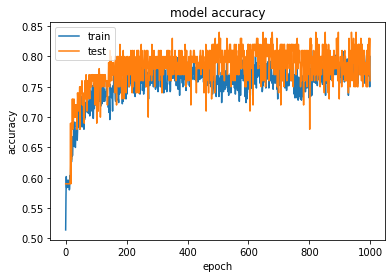

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 76.00%


(100, 256)
(100, 256)


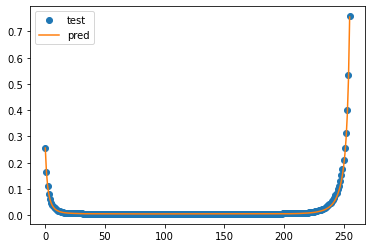

In [36]:
prediction = model.predict(X_test) 
print(prediction.shape) 
ypred=prediction
print(ypred.shape)
#for i in range(0,80):
#    plt.plot(ypred[i,:],'-')
    
#   print(ypred[i,-1],ypred[i,0])
i=40

#plt.plot(prediction.flatten())
plt.plot(y_test[i,:],'o')
plt.plot(ypred[i,:],'-')
plt.legend(['test', 'pred'], loc='best')

#print(ypred[i,-1],ypred[i,0])
#print(y_test[i,-1],y_test[i,0])
#plt.plot(ypred.flatten(),'o')
#plt.plot(y_test.flatten(),'*')
plt.show()

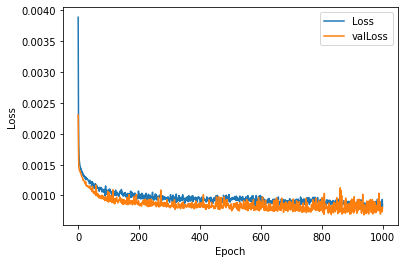

In [37]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='valLoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
from sklearn import metrics
from math import sqrt
meanAbErr = metrics.mean_absolute_error(y_test, ypred)
meanSqErr = metrics.mean_squared_error(y_test, ypred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, ypred))

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.007681929072745857
Mean Square Error: 0.0008079156414821432
Root Mean Square Error: 0.028423856907220442


In [39]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print("%s: %.4f%%" % (model.metrics_names[1], score[1]*100))

Test loss: 0.0008079156395979226
accuracy: 76.0000%
